### Imports

In [1]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

## Leitura do ficheiro

In [2]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

In [3]:
file = data_folder / "QuebrasJuntoInc.xlsx"
QuebrasFinal = pd.read_excel(file)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828.0,"0,0029345","0,0000443","0,0024563",...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549.0,"0,0029335","0,0001770","0,0165009",...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459.0,"0,0192281","0,0002655","0,0359047",...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102.0,"0,0000000","0,0000000","0,0000000",...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731.0,"0,0044221","0,0001549","0,0100377",...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2.0,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1.0,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1.0,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1.0,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [4]:
# Colocar datetime
QuebrasFinal["Data do incidente"] = pd.to_datetime(QuebrasFinal["Data do incidente"])

# Remover colunas desnecessárias
columnsRemove = ['Qualidade de Energia Elétrica', 'Qualidade de Serviço Comercial', 'Fundamentação']
QuebrasFinal = QuebrasFinal.drop(columns=columnsRemove)

# Substituir as vírgulas por pontos nas colunas supostamente numéricas
colunas_string = QuebrasFinal.iloc[:, 5:33].select_dtypes(include=['object']).columns
QuebrasFinal[colunas_string] = QuebrasFinal[colunas_string].replace(',', '.', regex=True)

QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828.0,0.0029345,0.0000443,0.0024563,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549.0,0.0029335,0.0001770,0.0165009,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459.0,0.0192281,0.0002655,0.0359047,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102.0,0.0000000,0.0000000,0.0000000,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731.0,0.0044221,0.0001549,0.0100377,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2.0,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1.0,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1.0,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1.0,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [5]:
TT = ""
while (TT != "BT") and (TT != "MT"):
    TT = input("Queres que tipo de Tensão? (BT, MT)")
    print(TT)

QuebrasFinal = QuebrasFinal[QuebrasFinal["Nível de Tensão"] == TT]
QuebrasFinal.drop("Nível de Tensão", axis = 1)

Queres que tipo de Tensão? (BT, MT) BT


BT


,Código do Relatório,Concelho,Data do incidente,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,Veículos,178,102.0,0.0000000,0.0000000,0.0000000,0.0000000,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
5,EDPD_2018_JAN_T_6,Esposende,2018-01-12,Escavações,76,60.0,0.0000000,0.0000000,0.0000000,0.0000000,...,126.0,0.000000,6.2,12.5,0.1,156.0,326.0,NaN,NaN,1.4
8,EDPD_2018_JAN_T_9,Amarante,2018-01-13,Incêndio,839,66.0,0.0000000,0.0000000,0.0000000,0.0000000,...,153.7,1.000000,9.6,13.2,6.1,159.0,163.0,3.4,17.4,18.3
31,EDPD_2018_FEV_T_4,Mirandela,2018-02-04,Veículos,430,89.0,0.0000000,0.0000000,0.0000000,0.0000000,...,279.0,1.000000,3.7,9.0,-0.6,329.0,315.0,2.8,10.2,0.0
41,EDPD_2018_FEV_T_14,Vila Nova De Famalicão,2018-02-09,Veículos,419,69.0,0.0000000,0.0000000,0.0000000,0.0000000,...,131.1,0.794118,7.6,12.9,3.6,18.0,338.0,NaN,NaN,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7299,EDPD_2017_NOV_T_61,Esposende,2017-11-25,Escavações,235,2.0,0,0,0,0,...,119.8,0.000000,12.5,17.7,6.1,28.0,326.0,NaN,NaN,1.3
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,Veículos,220,2.0,0,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,Veículos,92,1.0,0,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,Veículos,121,1.0,0,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1


In [6]:
# Lista das colunas a serem convertidas
colunas_para_converter = ['Duração incidente (min)', 'TIEPI MT (min)', 'SAIFI MT (#)', 
                          'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)']

# Converter as colunas para o tipo float
QuebrasFinal[colunas_para_converter] = QuebrasFinal[colunas_para_converter].apply(pd.to_numeric, errors='coerce')


C:\Users\diogo\AppData\Local\Temp\ipykernel_22328\1100263569.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QuebrasFinal[colunas_para_converter] = QuebrasFinal[colunas_para_converter].apply(pd.to_numeric, errors='coerce')


## Estandardizar/Normalizar os dados

In [7]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas

Index(['Duração incidente (min)', 'N.º clientes afetados', 'TIEPI MT (min)',
       'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)',
       'SAIDI BT (min)', 'Dia', 'Mês', 'Ano', 'Densidade Populacional',
       'População Residente', 'Setor Primário', 'Setor Secundário',
       'Setor Terciário', 'Indice de Envelhecimento', 'Rural', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD'],
      dtype='object')

In [8]:
# # Escolher o que queres
# _ = False

# if _ == True:
#     # Criar o objeto do normalizador Min-Max
#     scaler = MinMaxScaler()
    
#     # Normalizar as colunas numéricas
#     QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# else:
#     # Criar o objeto do estandardizador
#     scaler = StandardScaler()
    
#     # Estandardizar as colunas numéricas
#     QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# # Resultado final
# QuebrasFinal

## Imputação dos dados

In [9]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal.reset_index(drop = True)


C:\Users\diogo\AppData\Local\Temp\ipykernel_22328\3166614405.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])


,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102.0,0.0,0.0,0.0,...,156.4,0.923077,12.4,15.1,9.1,288.000000,225.000000,3.600000,13.900000,13.200000
1,EDPD_2018_JAN_T_6,Esposende,2018-01-12,BT,Escavações,76.0,60.0,0.0,0.0,0.0,...,126.0,0.000000,6.2,12.5,0.1,156.000000,326.000000,2.596959,9.875197,1.400000
2,EDPD_2018_JAN_T_9,Amarante,2018-01-13,BT,Incêndio,839.0,66.0,0.0,0.0,0.0,...,153.7,1.000000,9.6,13.2,6.1,159.000000,163.000000,3.400000,17.400000,18.300000
3,EDPD_2018_FEV_T_4,Mirandela,2018-02-04,BT,Veículos,430.0,89.0,0.0,0.0,0.0,...,279.0,1.000000,3.7,9.0,-0.6,329.000000,315.000000,2.800000,10.200000,0.000000
4,EDPD_2018_FEV_T_14,Vila Nova De Famalicão,2018-02-09,BT,Veículos,419.0,69.0,0.0,0.0,0.0,...,131.1,0.794118,7.6,12.9,3.6,18.000000,338.000000,2.605871,9.834954,3.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2.0,0.0,0.0,0.0,...,119.8,0.000000,12.5,17.7,6.1,28.000000,326.000000,2.684677,9.430428,1.300000
3635,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2.0,0.0,0.0,0.0,...,141.7,1.000000,10.3,14.3,6.3,201.728515,213.599005,2.923169,9.762805,0.000000
3636,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1.0,0.0,0.0,0.0,...,134.6,0.000000,16.4,20.6,14.8,197.169648,217.930059,3.034081,9.791903,5.402933
3637,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1.0,0.0,0.0,0.0,...,134.6,0.000000,17.9,22.6,14.6,194.406573,220.084791,2.857391,9.986376,8.100000


In [10]:
QuebrasFinal[QuebrasFinal.isna().any(axis=1)]

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD


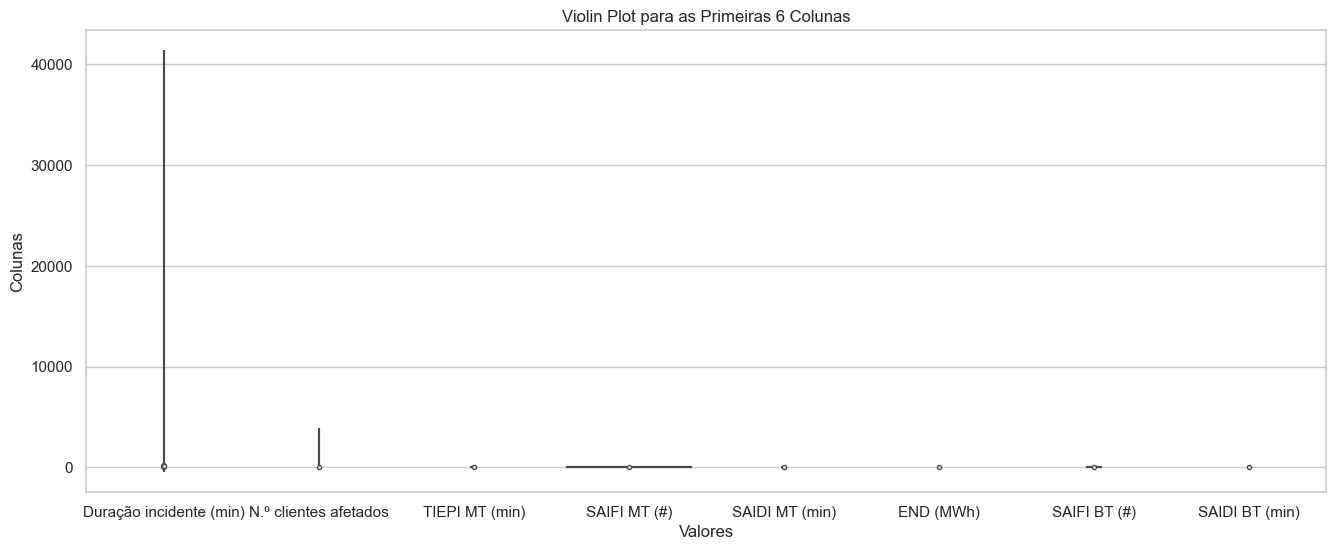

In [11]:
sns.set(style="whitegrid")

# Selecionar apenas as primeiras 6 colunas
subset_quebras_final = QuebrasFinal.iloc[:, 5:13]

# Plotar violin plot para as primeiras 6 colunas
plt.figure(figsize=(16, 6))
sns.violinplot(data=subset_quebras_final)
plt.title("Violin Plot para as Primeiras 6 Colunas")
plt.xlabel("Valores")
plt.ylabel("Colunas")
plt.show()

In [12]:
QuebrasFinal["Causa do incidente"].unique()

array(['Veículos', 'Escavações', 'Incêndio', 'Animais Não Aves',
       'Abate De Árvores', 'Intervenções À Superficie', 'Furtos',
       'Descarga Atmosférica Directa', 'Vento Intensidade Excepcional',
       'Malfeitoria/Vandalismo', 'Inundações Imprevisíveis',
       'Desabamento De Muros/Outras Cons', 'Corpos Estranhos Na Rede',
       'Risco Iminente Pessoas Ou Bens', 'Aves',
       'Desabamento De Muros/Outras Construções', 'Sabotagem',
       'Deslizamento De Terras', 'Trabalhos De Terceiros ( Gruas,... )',
       'Ruptura De Canal. De Fluídos', 'Malfeitorioa (Vandalismo)'],
      dtype=object)

## _Fogo_ --

In [13]:
CausaEstudo = 'Incêndio'

In [14]:
Visualizar = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby('Dia')[['TIEPI MT (min)', 'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']].mean().reset_index()
Visualizar

,Dia,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),SAIDI BT (min),T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,1.0,0.0,0.0,0.0,0.0,1.240000e-06,0.000174,15.440000,21.420000,10.320000,228.825854,248.699812,2.783746,9.091588,0.920000
1,2.0,0.0,0.0,0.0,0.0,1.785714e-06,0.000235,15.400000,19.842857,11.042857,175.251498,207.151049,3.068663,10.315222,4.642857
2,3.0,0.0,0.0,0.0,0.0,3.433333e-06,0.000397,23.077778,31.277778,16.422222,177.351553,220.513041,2.939116,9.588920,0.200000
3,4.0,0.0,0.0,0.0,0.0,3.560000e-06,0.000550,23.280000,32.450000,15.370000,271.005047,259.209548,2.466044,8.446911,0.000000
4,5.0,0.0,0.0,0.0,0.0,9.571429e-07,0.000203,17.509279,24.344638,11.228153,304.253017,302.560367,2.648451,9.942193,1.214286
5,6.0,0.0,0.0,0.0,0.0,3.778571e-06,0.000589,21.319478,30.415587,14.962471,208.058954,223.172348,2.866884,9.873837,0.564286
6,7.0,0.0,0.0,0.0,0.0,2.603846e-06,0.000376,21.999667,30.371445,14.922896,178.305419,212.204011,3.249252,10.939168,0.607692
7,8.0,0.0,0.0,0.0,0.0,4.295455e-06,0.000607,24.097721,32.041523,17.211978,182.182834,208.946489,3.164109,10.308245,0.118182
8,9.0,0.0,0.0,0.0,0.0,3.504348e-06,0.000844,21.029391,27.074982,15.375966,181.381611,222.101954,3.291007,10.961695,0.092621
9,10.0,0.0,0.0,0.0,0.0,4.300000e-06,0.000475,20.516523,28.925426,13.473483,194.364670,191.734437,2.798636,9.538496,-0.113492


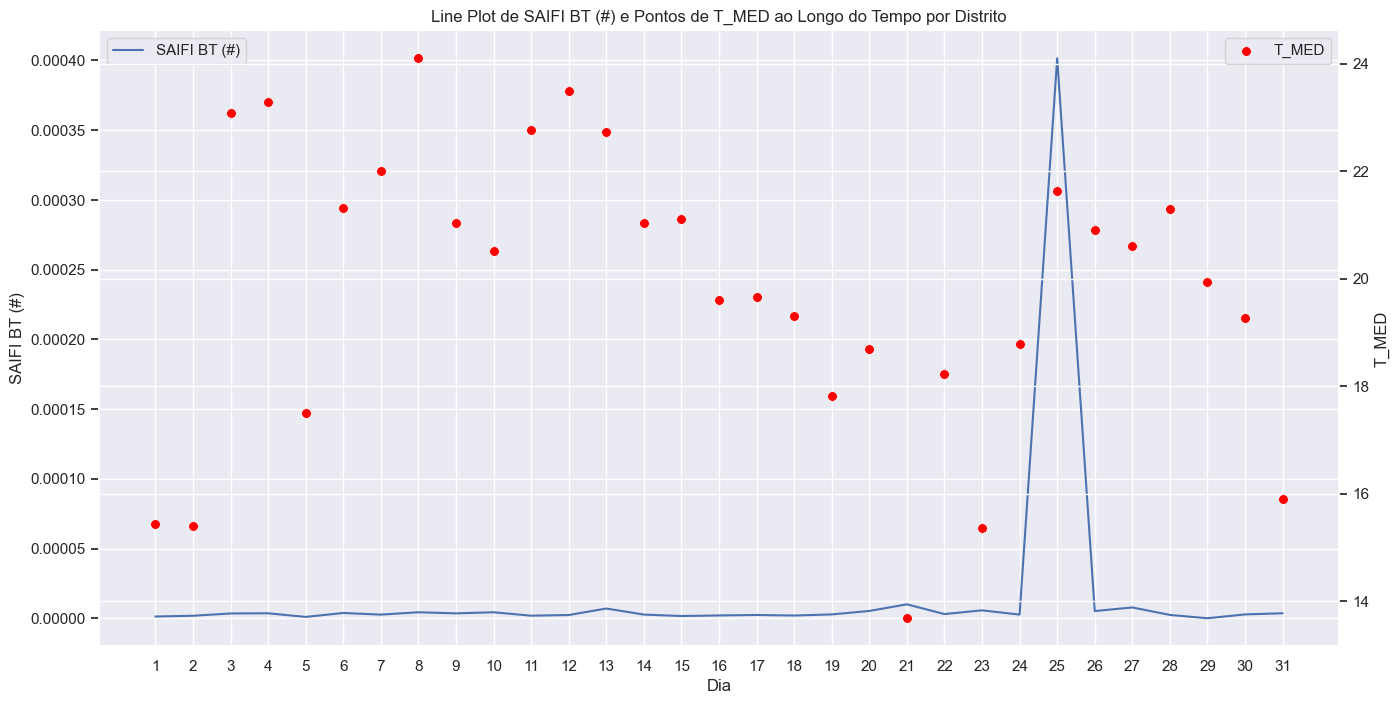

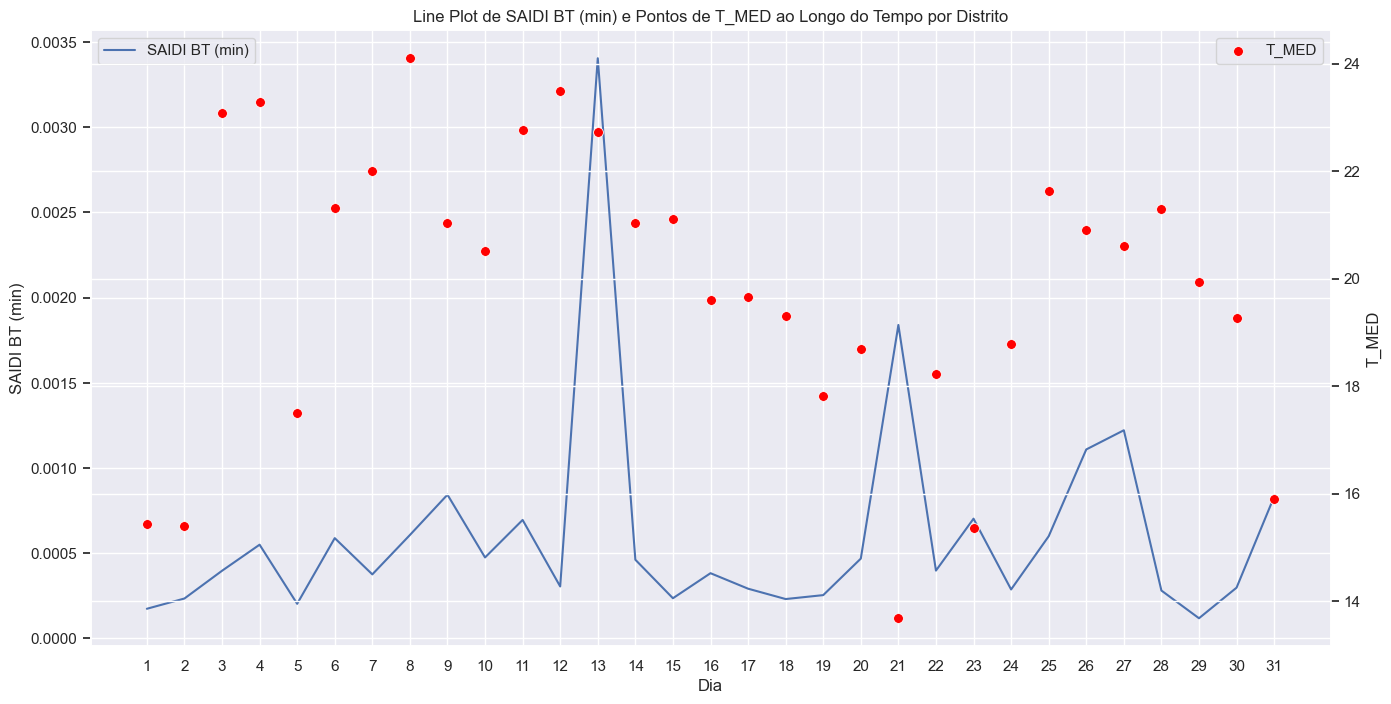

In [15]:
# Converter 'Dia' para numérico
Visualizar['Dia'] = Visualizar['Dia'].astype(int)

# Obter todos os dias do intervalo
todos_os_dias = range(Visualizar['Dia'].min(), Visualizar['Dia'].max() + 1)

if TT == "BT":
    variaveis = ['SAIFI BT (#)', 'SAIDI BT (min)']
else:
    variaveis = ["TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)", "END (MWh)"]

# Definir o estilo do Seaborn
sns.set_style("darkgrid")
tips = sns.load_dataset('tips')
sns.set_context('notebook', font_scale = 1)

IPMA = "T_MED"

# Loop sobre as variáveis
for i in variaveis:
    # Criar o line plot para 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)'
    plt.figure(figsize=(16, 8))
    ax1 = sns.lineplot(data=Visualizar, x='Dia', y=i, label=i, dashes=False, markers=True)

    # Adicionar legenda à esquerda
    plt.legend(loc='upper left')
    
    # Adicionar pontos para 'T_MED' em cada dia
    ax2 = ax1.twinx()
    sns.scatterplot(data=Visualizar, x='Dia', y=IPMA, color='red', s=50, ax=ax2, label=IPMA)

    # Definir todos os dias no eixo x
    plt.xticks(todos_os_dias)
    
    # Adicionar título e etiquetas dos eixos
    plt.title(f'Line Plot de {i} e Pontos de {IPMA} ao Longo do Tempo por Distrito')
    ax1.set_xlabel('Dia')
    ax1.set_ylabel(i)
    ax2.set_ylabel(IPMA)
    
    # Mostrar o gráfico
    plt.show()


## _Descarga Atmosférica Directa_ --

In [16]:
CausaEstudo = 'Descarga Atmosférica Directa'

In [17]:
Visualizar = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby('Dia')[['TIEPI MT (min)', 'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']].mean().reset_index()
Visualizar

,Dia,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),SAIDI BT (min),T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,1.0,0.000000,0.000000,0.000000,0.000000,1.500000e-05,0.005950,17.400000,23.900000,12.150000,293.500000,312.500000,1.450000,5.550000,2.750000
1,2.0,0.000000,0.000000,0.000000,0.000000,9.000000e-06,0.001730,15.700000,23.000000,12.100000,19.000000,96.000000,1.700000,10.600000,5.900000
2,3.0,0.000000,0.000000,0.000000,0.000000,1.450000e-05,0.002284,12.550000,17.000000,10.250000,223.000000,247.500000,3.700000,16.900000,9.449799
3,4.0,0.000000,0.000000,0.000000,0.000000,1.300000e-05,0.001300,11.800000,15.300000,7.400000,336.000000,326.000000,1.800000,13.700000,11.200000
4,5.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000870,10.950000,13.400000,8.900000,192.000000,248.000000,2.475692,11.912566,24.000000
5,6.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000110,22.300000,29.300000,17.000000,233.265613,238.714025,3.088099,10.110602,0.000000
6,7.0,0.000000,0.000000,0.000000,0.000000,1.000000e-05,0.001000,23.100000,31.300000,18.000000,349.000000,197.000000,3.600000,10.500000,0.000000
7,8.0,0.000000,0.000000,0.000000,0.000000,1.330000e-05,0.000067,22.200000,30.900000,14.300000,31.000000,51.000000,4.700000,17.500000,7.600000
8,9.0,0.000000,0.000000,0.000000,0.000000,2.000000e-07,0.000027,21.300000,28.500000,16.400000,31.000000,68.000000,3.900000,10.500000,3.000000
9,11.0,0.000000,0.000000,0.000000,0.000000,4.510000e-05,0.011285,21.800000,28.400000,17.300000,229.000000,360.000000,1.300000,9.900000,0.100000


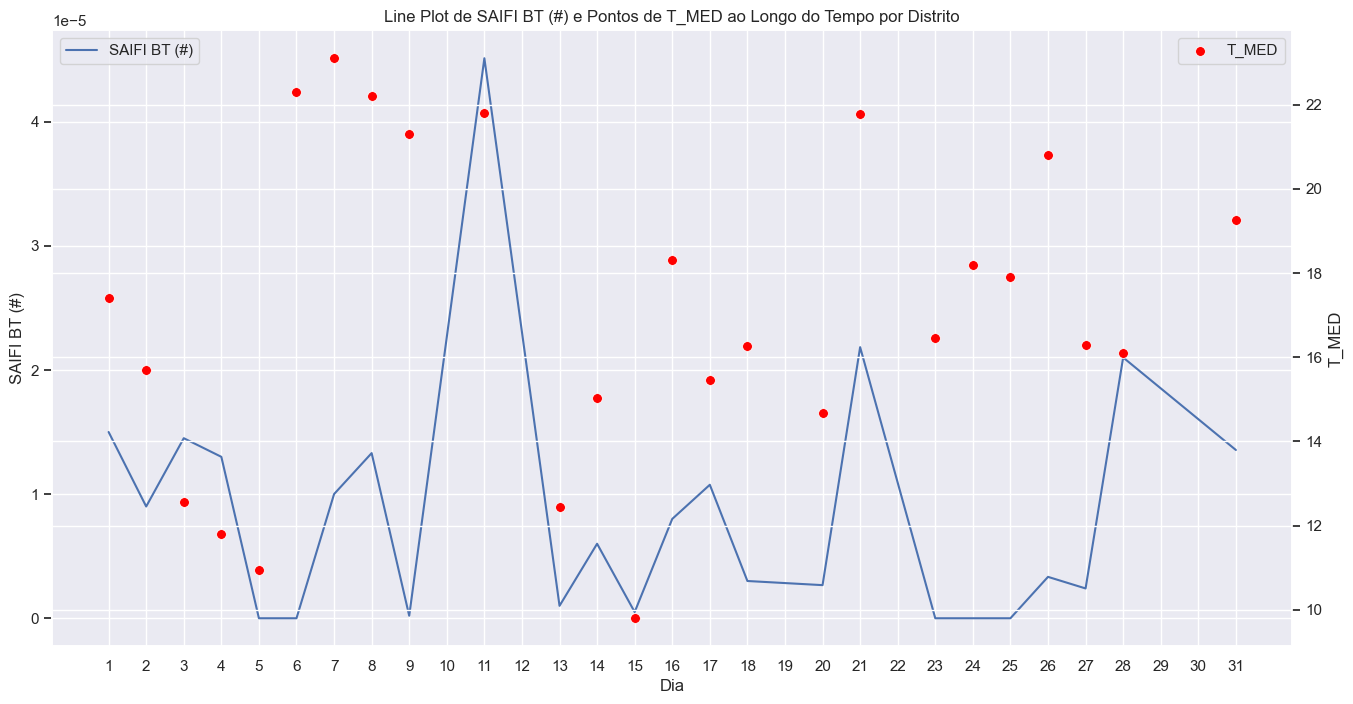

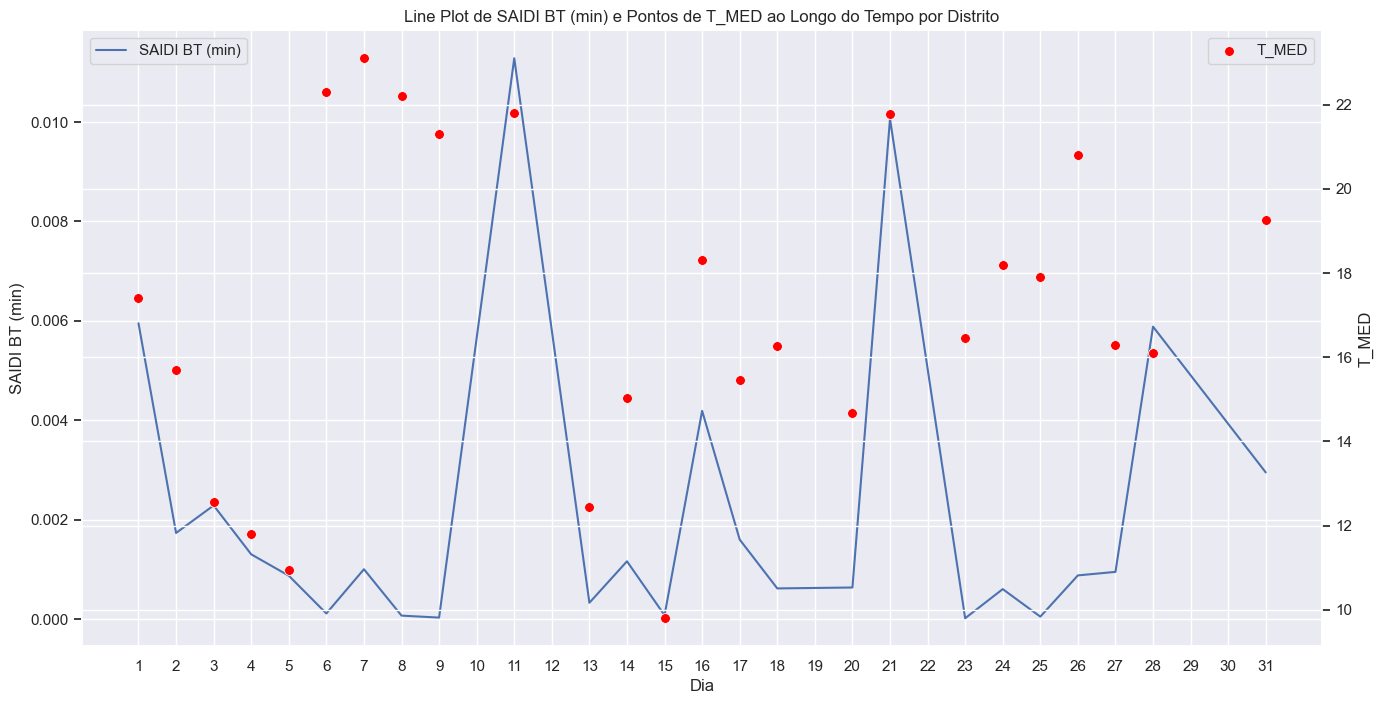

In [18]:
# Converter 'Dia' para numérico
Visualizar['Dia'] = Visualizar['Dia'].astype(int)

# Obter todos os dias do intervalo
todos_os_dias = range(Visualizar['Dia'].min(), Visualizar['Dia'].max() + 1)

if TT == "BT":
    variaveis = ['SAIFI BT (#)', 'SAIDI BT (min)']
else:
    variaveis = ["TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)", "END (MWh)"]

# Definir o estilo do Seaborn
sns.set_style("darkgrid")
tips = sns.load_dataset('tips')
sns.set_context('notebook', font_scale = 1)

IPMA = "T_MED"

# Loop sobre as variáveis
for i in variaveis:
    # Criar o line plot para 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)'
    plt.figure(figsize=(16, 8))
    ax1 = sns.lineplot(data=Visualizar, x='Dia', y=i, label=i, dashes=False, markers=True)

    # Adicionar legenda à esquerda
    plt.legend(loc='upper left')
    
    # Adicionar pontos para 'T_MED' em cada dia
    ax2 = ax1.twinx()
    sns.scatterplot(data=Visualizar, x='Dia', y=IPMA, color='red', s=50, ax=ax2, label=IPMA)

    # Definir todos os dias no eixo x
    plt.xticks(todos_os_dias)
    
    # Adicionar título e etiquetas dos eixos
    plt.title(f'Line Plot de {i} e Pontos de {IPMA} ao Longo do Tempo por Distrito')
    ax1.set_xlabel('Dia')
    ax1.set_ylabel(i)
    ax2.set_ylabel(IPMA)
    
    # Mostrar o gráfico
    plt.show()


In [19]:
# # Converter 'Dia' para numérico
# Visualizar['Dia'] = Visualizar['Dia'].astype(int)

# # Obter todos os dias do intervalo
# todos_os_dias = range(1, 31)

# # Criar um DataFrame com todos os dias do intervalo
# todos_os_dias_df = pd.DataFrame({'Dia': todos_os_dias})

# # Mesclar o DataFrame com todos os dias com o DataFrame original para preencher os dias sem valores com zero
# Visualizar = pd.merge(todos_os_dias_df, Visualizar, on='Dia', how='left').fillna(0)

# if TT == "BT":
#     variaveis = ['SAIFI BT (#)', 'SAIDI BT (min)']
# else:
#     variaveis = ["TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)", "END (MWh)"]

# # Definir o estilo do Seaborn
# sns.set_style("darkgrid")
# tips = sns.load_dataset('tips')
# sns.set_context('notebook', font_scale = 1)

# IPMA = "T_MED"

# # Loop sobre as variáveis
# for i in variaveis:
#     # Criar o line plot para 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)'
#     plt.figure(figsize=(16, 8))
#     ax1 = sns.lineplot(data=Visualizar, x='Dia', y=i, label=i, dashes=False, markers=True, marker='o')

#     # Adicionar legenda à esquerda
#     plt.legend(loc='upper left')
    
#     # Adicionar pontos para 'T_MED' em cada dia
#     ax2 = ax1.twinx()
#     sns.barplot(data=Visualizar, x='Dia', y=IPMA, ax=ax2, alpha=0.3)

#     # Definir todos os dias no eixo x
#     plt.xticks(todos_os_dias)
    
#     # Adicionar título e etiquetas dos eixos
#     plt.title(f'Line Plot de {i} e Pontos de {IPMA} ao Longo do Tempo por Distrito')
#     ax1.set_xlabel('Dia')
#     ax1.set_ylabel(i)
#     ax2.set_ylabel(IPMA)
    
#     # Mostrar o gráfico
#     plt.show()

## _Vento Intensidade Excepcional_ --

In [20]:
CausaEstudo = 'Vento Intensidade Excepcional'

In [21]:
Visualizar = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby('Dia')[['TIEPI MT (min)', 'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']].mean().reset_index()
Visualizar

,Dia,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),SAIDI BT (min),T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,2.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000027,2.700000,5.700000,0.700000,138.000000,118.000000,4.800000,13.500000,0.700000
1,3.0,0.0,0.0,0.0,0.0,2.000000e-07,0.000010,13.800000,15.100000,12.900000,141.000000,141.000000,5.000000,14.400000,11.900000
2,6.0,0.0,0.0,0.0,0.0,3.500000e-06,0.000298,8.600000,14.600000,4.400000,212.000000,259.000000,3.200000,11.100000,1.300000
3,7.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000032,8.500000,11.400000,2.700000,293.000000,338.000000,4.700000,13.700000,15.700000
4,10.0,0.0,0.0,0.0,0.0,4.700000e-06,0.003413,13.138513,17.844827,8.883593,299.300000,303.700000,4.028421,19.242806,5.780000
5,11.0,0.0,0.0,0.0,0.0,4.000000e-06,0.000610,11.361583,16.586678,6.972405,136.500000,259.000000,2.850000,11.850000,14.850000
6,13.0,0.0,0.0,0.0,0.0,8.100000e-06,0.001047,19.250000,24.550000,14.100000,180.500000,249.500000,4.700000,23.950000,18.100000
7,14.0,0.0,0.0,0.0,0.0,7.000000e-06,0.000394,16.299576,21.397560,11.613269,204.000000,236.000000,4.900000,18.100000,17.700000
8,15.0,0.0,0.0,0.0,0.0,7.450000e-06,0.000791,14.200000,17.500000,10.700000,198.000000,225.000000,3.400000,18.900000,64.500000
9,16.0,0.0,0.0,0.0,0.0,1.840000e-06,0.000259,15.640000,19.000000,10.960000,215.070009,220.252353,3.417200,14.285865,7.220000


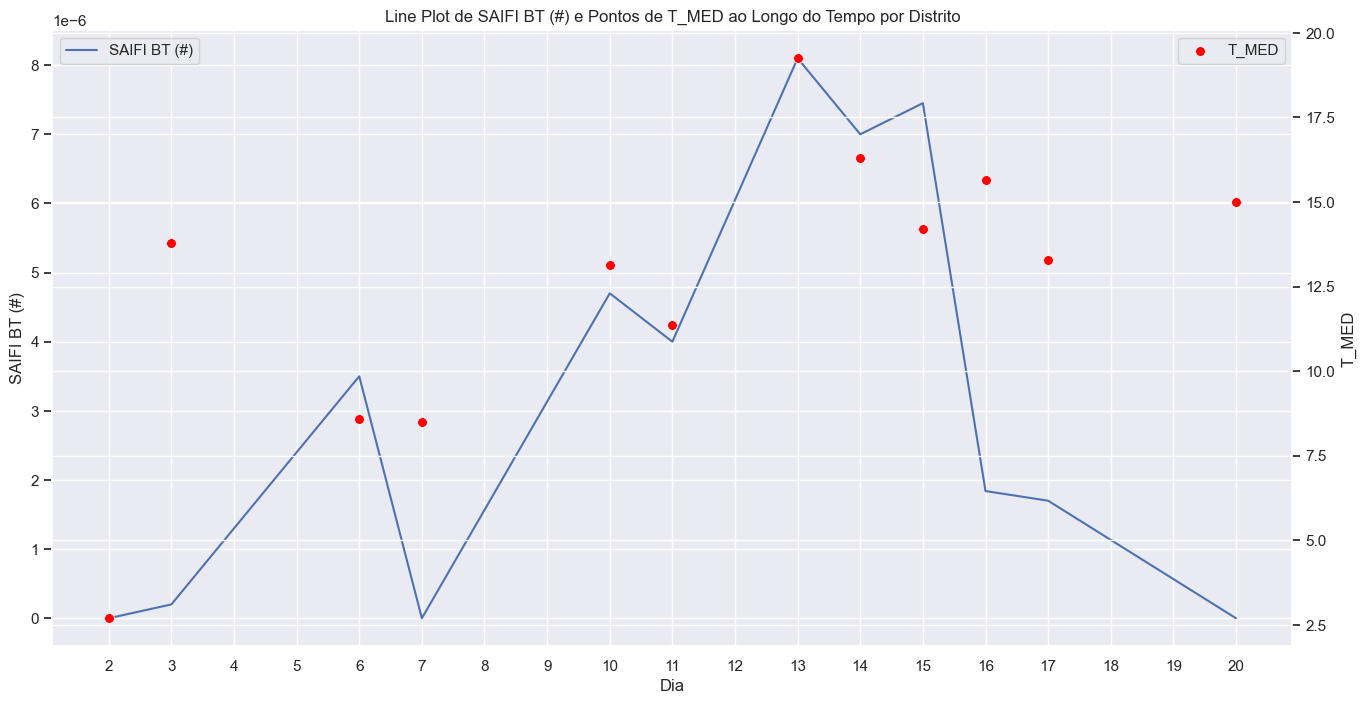

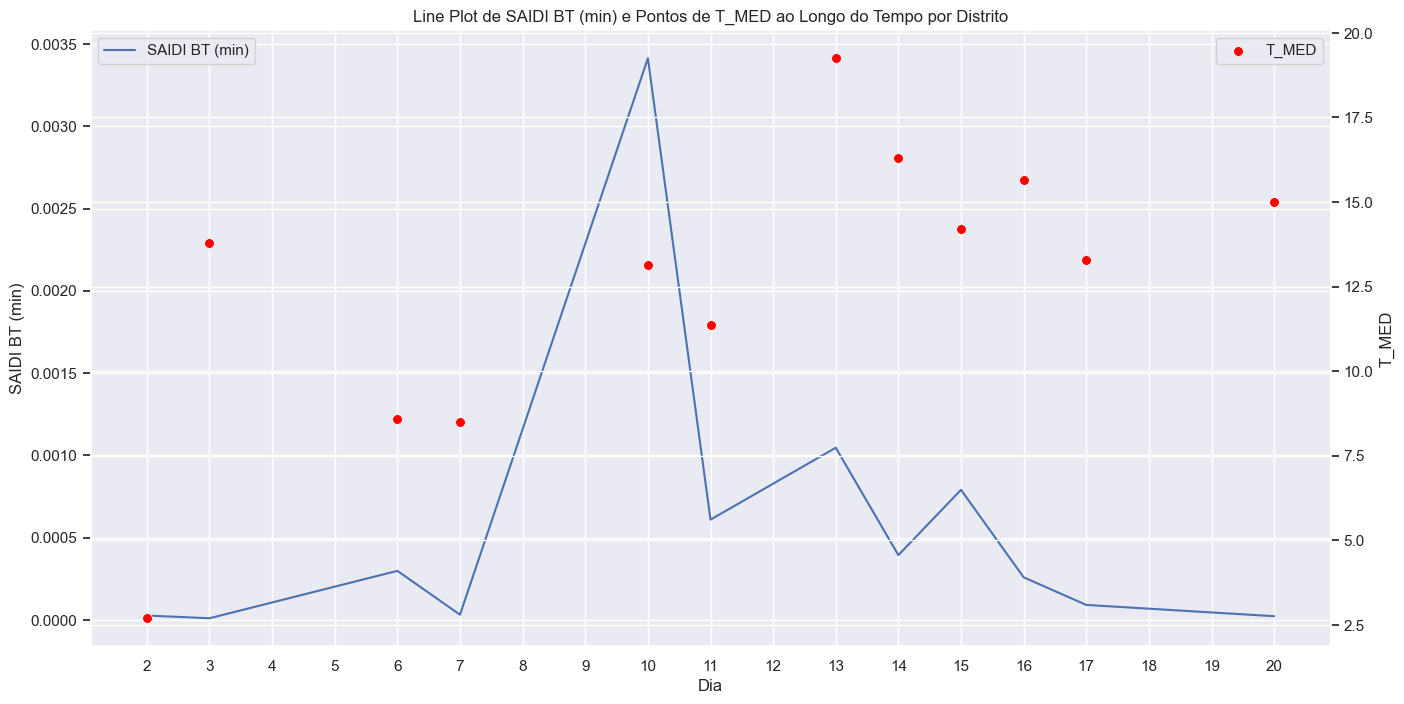

In [22]:
# Converter 'Dia' para numérico
Visualizar['Dia'] = Visualizar['Dia'].astype(int)

# Obter todos os dias do intervalo
todos_os_dias = range(Visualizar['Dia'].min(), Visualizar['Dia'].max() + 1)

if TT == "BT":
    variaveis = ['SAIFI BT (#)', 'SAIDI BT (min)']
else:
    variaveis = ["TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)", "END (MWh)"]

# Definir o estilo do Seaborn
sns.set_style("darkgrid")
tips = sns.load_dataset('tips')
sns.set_context('notebook', font_scale = 1)

IPMA = "T_MED"

# Loop sobre as variáveis
for i in variaveis:
    # Criar o line plot para 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)'
    plt.figure(figsize=(16, 8))
    ax1 = sns.lineplot(data=Visualizar, x='Dia', y=i, label=i, dashes=False, markers=True)

    # Adicionar legenda à esquerda
    plt.legend(loc='upper left')
    
    # Adicionar pontos para 'T_MED' em cada dia
    ax2 = ax1.twinx()
    sns.scatterplot(data=Visualizar, x='Dia', y=IPMA, color='red', s=50, ax=ax2, label=IPMA)

    # Definir todos os dias no eixo x
    plt.xticks(todos_os_dias)
    
    # Adicionar título e etiquetas dos eixos
    plt.title(f'Line Plot de {i} e Pontos de {IPMA} ao Longo do Tempo por Distrito')
    ax1.set_xlabel('Dia')
    ax1.set_ylabel(i)
    ax2.set_ylabel(IPMA)
    
    # Mostrar o gráfico
    plt.show()


## _Aves_ --

In [23]:
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102.0,0.0,0.0,0.0,...,156.4,0.923077,12.4,15.1,9.1,288.000000,225.000000,3.600000,13.900000,13.200000
5,EDPD_2018_JAN_T_6,Esposende,2018-01-12,BT,Escavações,76.0,60.0,0.0,0.0,0.0,...,126.0,0.000000,6.2,12.5,0.1,156.000000,326.000000,2.596959,9.875197,1.400000
8,EDPD_2018_JAN_T_9,Amarante,2018-01-13,BT,Incêndio,839.0,66.0,0.0,0.0,0.0,...,153.7,1.000000,9.6,13.2,6.1,159.000000,163.000000,3.400000,17.400000,18.300000
31,EDPD_2018_FEV_T_4,Mirandela,2018-02-04,BT,Veículos,430.0,89.0,0.0,0.0,0.0,...,279.0,1.000000,3.7,9.0,-0.6,329.000000,315.000000,2.800000,10.200000,0.000000
41,EDPD_2018_FEV_T_14,Vila Nova De Famalicão,2018-02-09,BT,Veículos,419.0,69.0,0.0,0.0,0.0,...,131.1,0.794118,7.6,12.9,3.6,18.000000,338.000000,2.605871,9.834954,3.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7299,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2.0,0.0,0.0,0.0,...,119.8,0.000000,12.5,17.7,6.1,28.000000,326.000000,2.684677,9.430428,1.300000
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2.0,0.0,0.0,0.0,...,141.7,1.000000,10.3,14.3,6.3,201.728515,213.599005,2.923169,9.762805,0.000000
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1.0,0.0,0.0,0.0,...,134.6,0.000000,16.4,20.6,14.8,197.169648,217.930059,3.034081,9.791903,5.402933
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1.0,0.0,0.0,0.0,...,134.6,0.000000,17.9,22.6,14.6,194.406573,220.084791,2.857391,9.986376,8.100000


In [24]:
CausaEstudo = 'Aves'

In [25]:
Visualizar = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby(["Mês", "Distrito"])[['TIEPI MT (min)', 'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']].mean().reset_index()
Visualizar

,Mês,Distrito,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),END (MWh),SAIFI BT (#),SAIDI BT (min),T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,2.0,Beja,0.0,0.0,0.0,0.0,1.000000e-05,0.001417,16.492864,22.248955,11.351084,225.315527,236.608133,2.938812,10.549796,2.298233
1,2.0,Setúbal,0.0,0.0,0.0,0.0,0.000000e+00,0.000070,16.478318,22.275077,11.369724,225.167046,247.402660,2.888314,10.445796,2.101602
2,3.0,Beja,0.0,0.0,0.0,0.0,0.000000e+00,0.000021,16.305168,21.863555,11.670479,230.000000,293.000000,3.700000,12.200000,12.600000
3,3.0,Leiria,0.0,0.0,0.0,0.0,1.000000e-06,0.000097,14.800000,17.200000,13.500000,294.000000,335.000000,2.200000,7.200000,2.961842
4,3.0,Setúbal,0.0,0.0,0.0,0.0,1.000000e-05,0.001700,11.100000,19.000000,2.600000,331.000000,304.000000,1.300000,5.700000,0.000000
5,3.0,Viana Do Castelo,0.0,0.0,0.0,0.0,5.200000e-06,0.000299,9.700000,18.800000,2.900000,193.999846,243.490854,2.433769,9.647877,0.000000
6,4.0,Portalegre,0.0,0.0,0.0,0.0,0.000000e+00,0.000023,20.800000,26.800000,14.800000,221.764741,220.802768,2.100000,6.100000,0.000000
7,5.0,Beja,0.0,0.0,0.0,0.0,0.000000e+00,0.000021,16.478872,22.185600,11.515276,341.000000,23.000000,3.000000,8.000000,0.000000
8,5.0,Coimbra,0.0,0.0,0.0,0.0,2.000000e-06,0.000109,14.000000,20.400000,7.100000,360.000000,309.000000,2.900000,10.100000,0.000000
9,5.0,Faro,0.0,0.0,0.0,0.0,1.000000e-05,0.001660,19.400000,23.100000,17.400000,97.000000,90.000000,6.300000,12.700000,0.300000


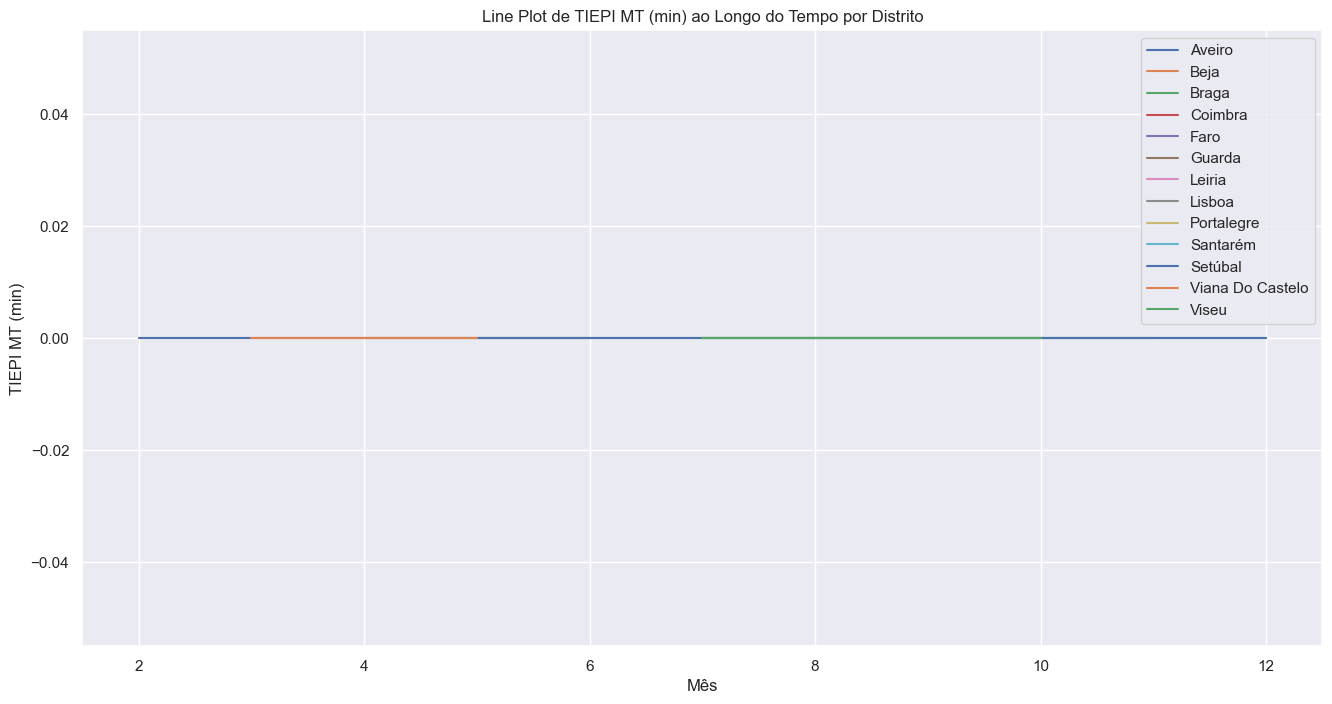

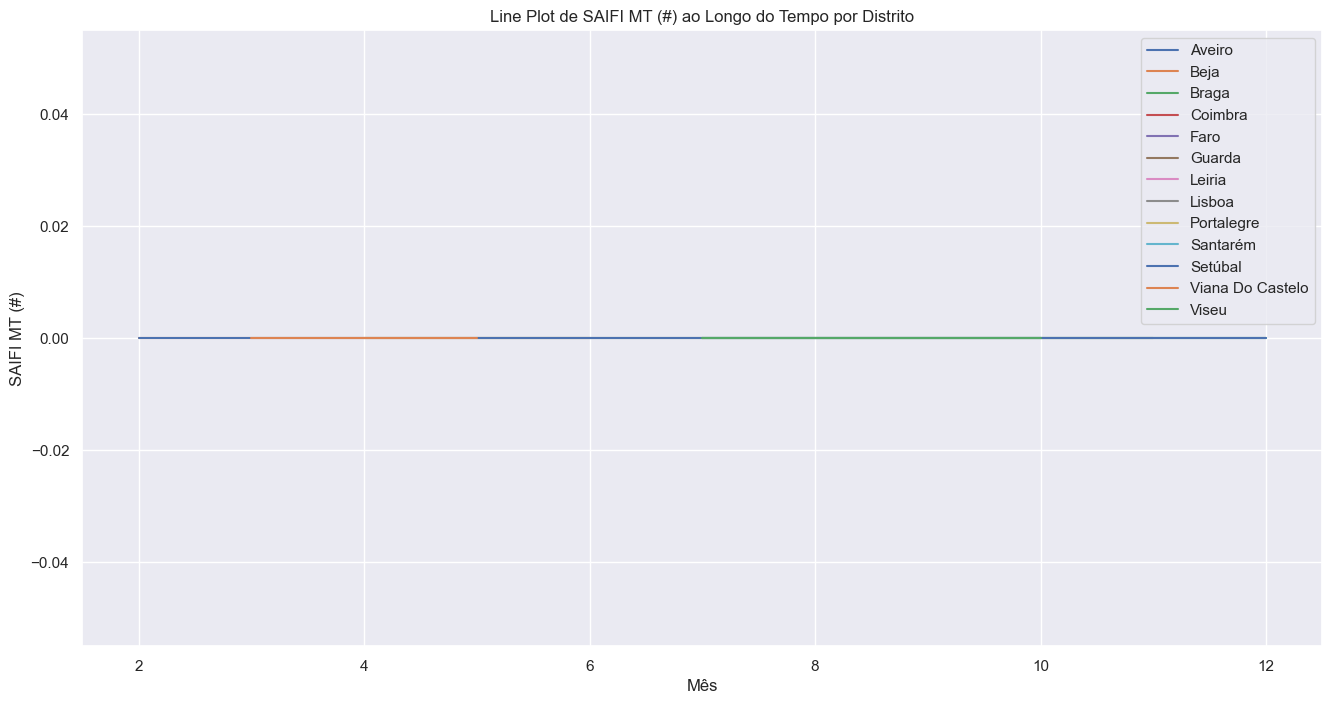

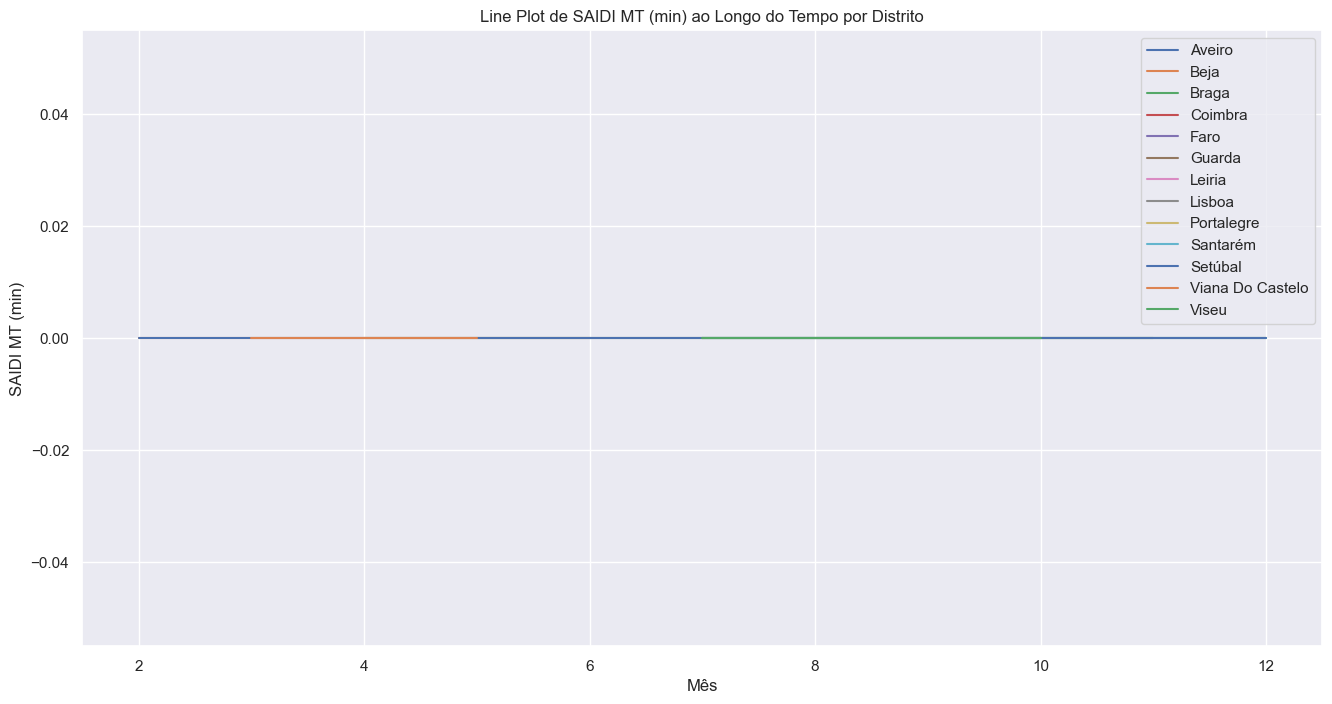

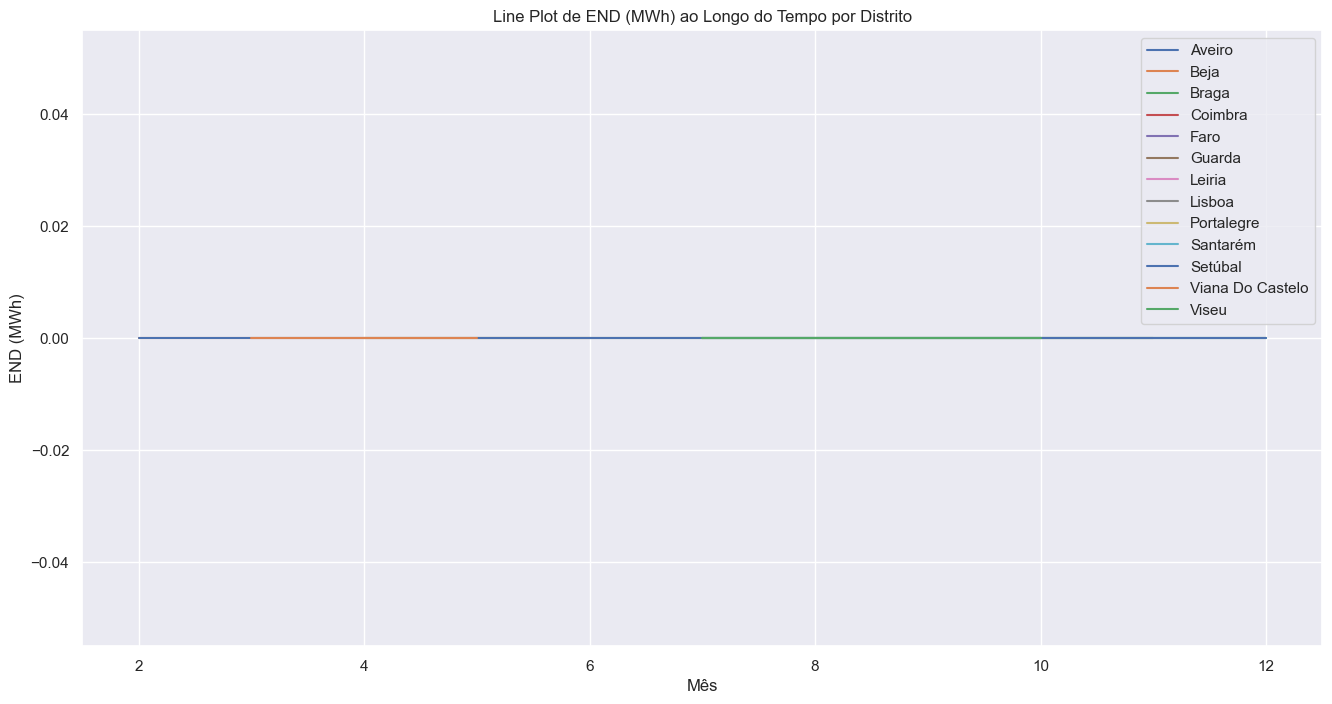

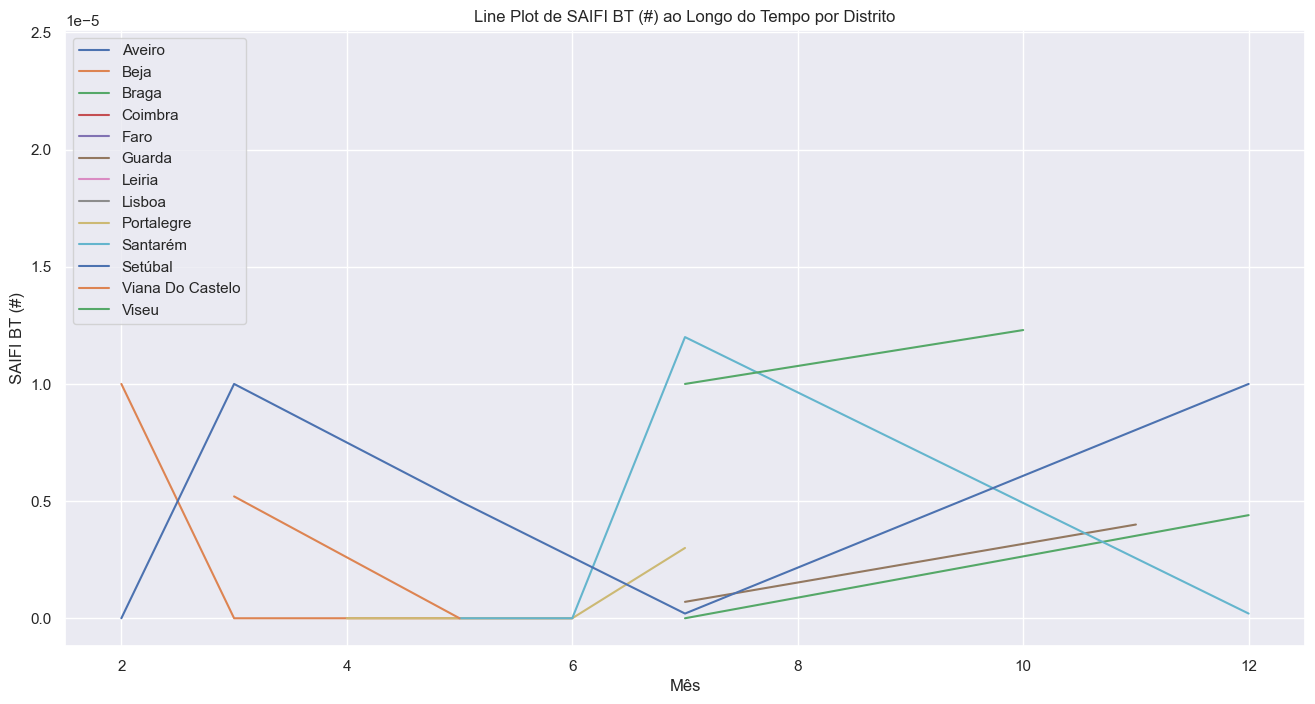

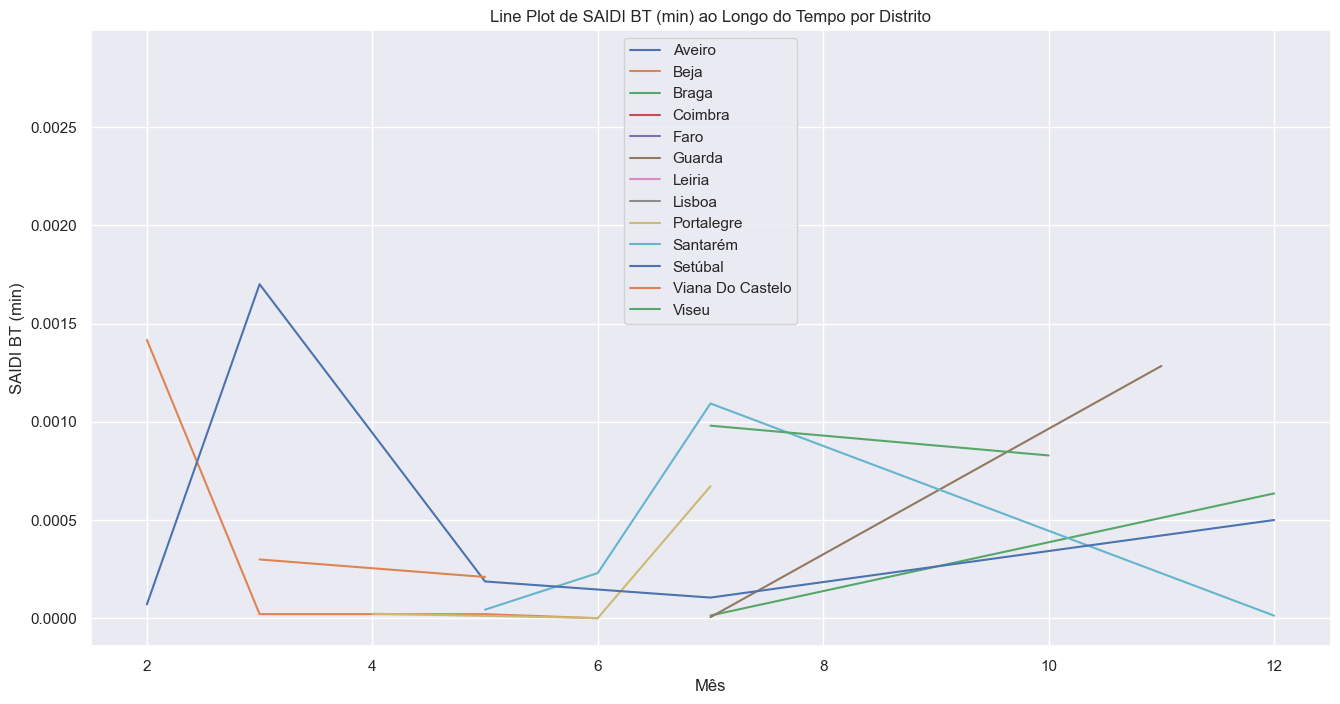

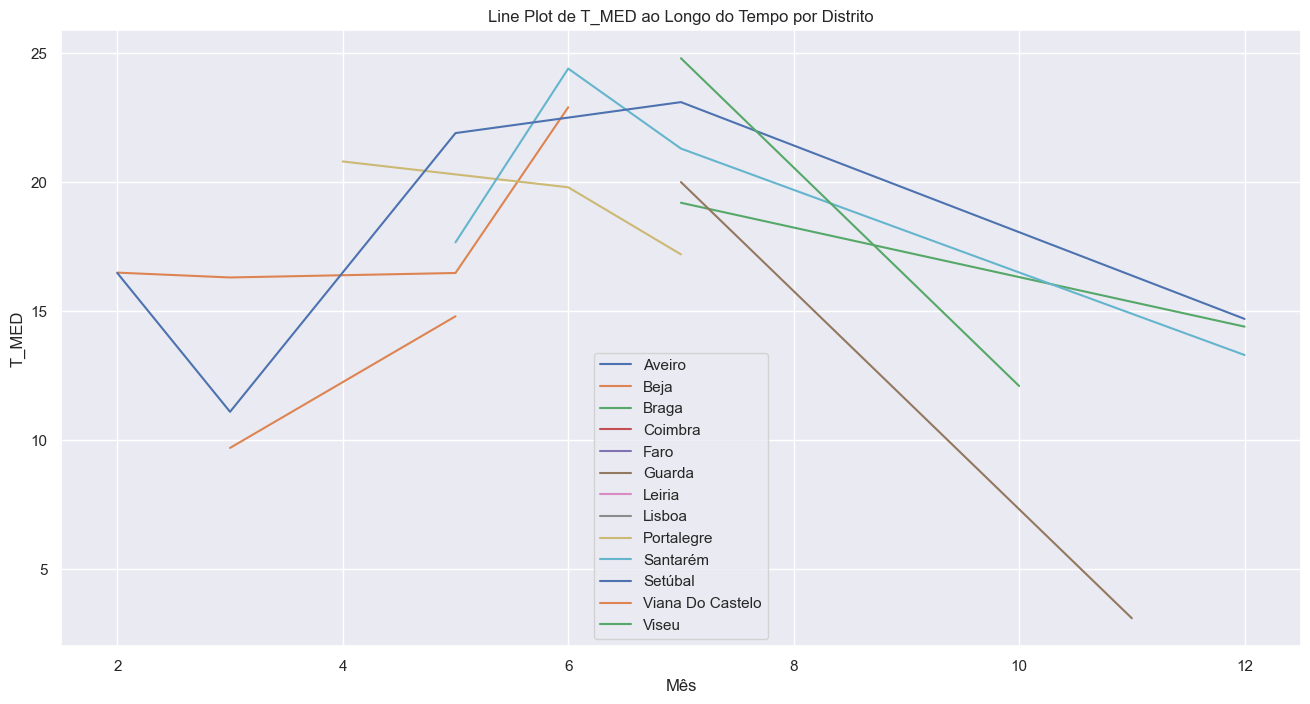

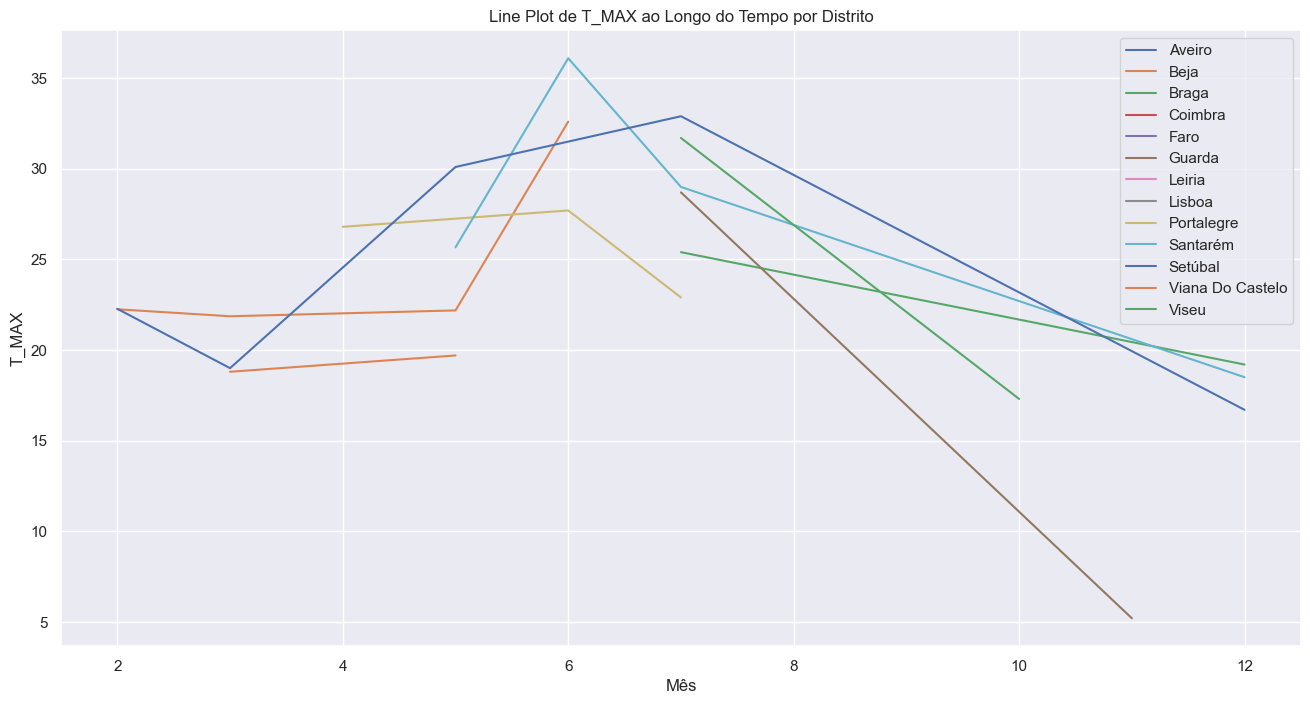

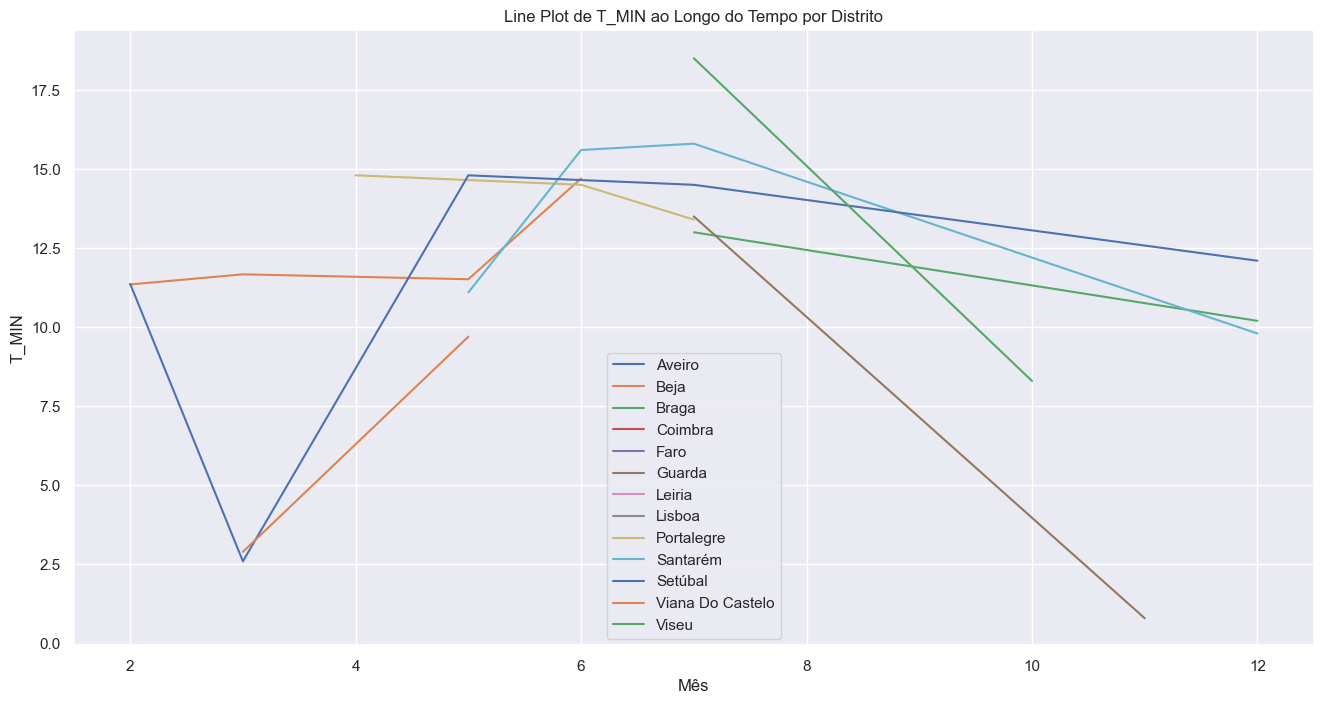

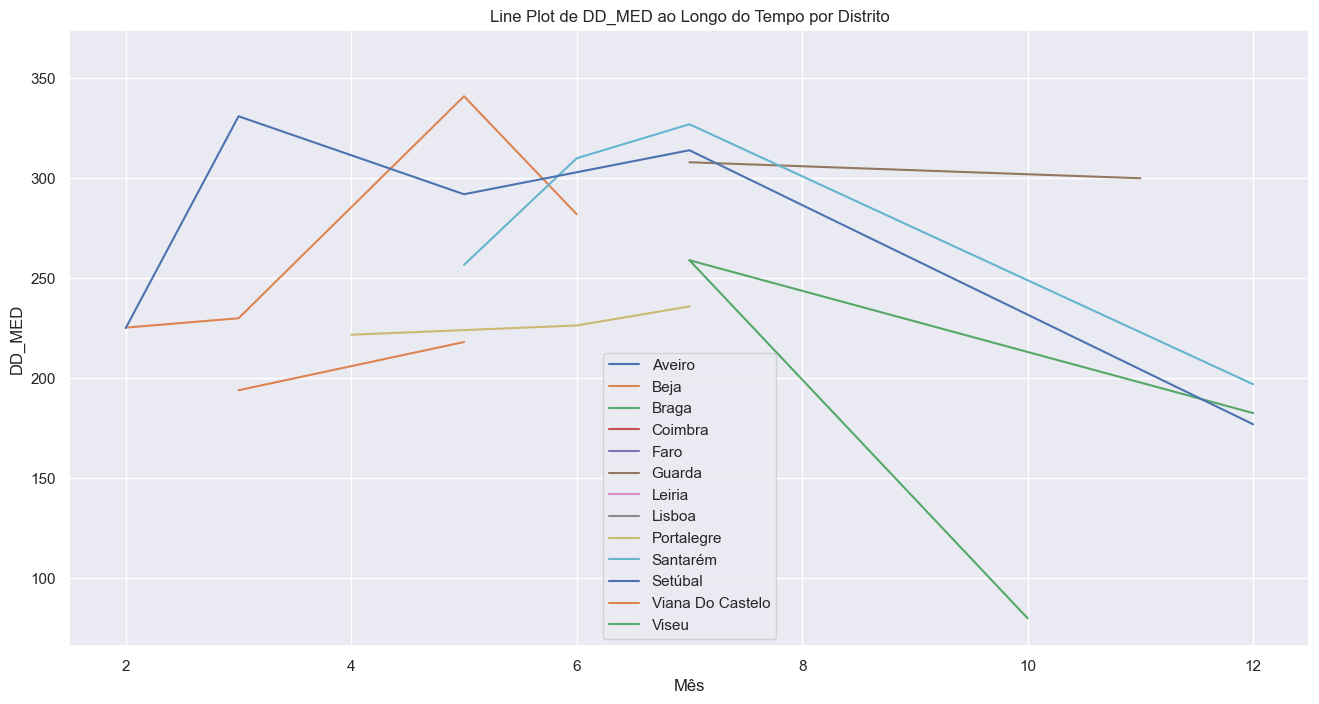

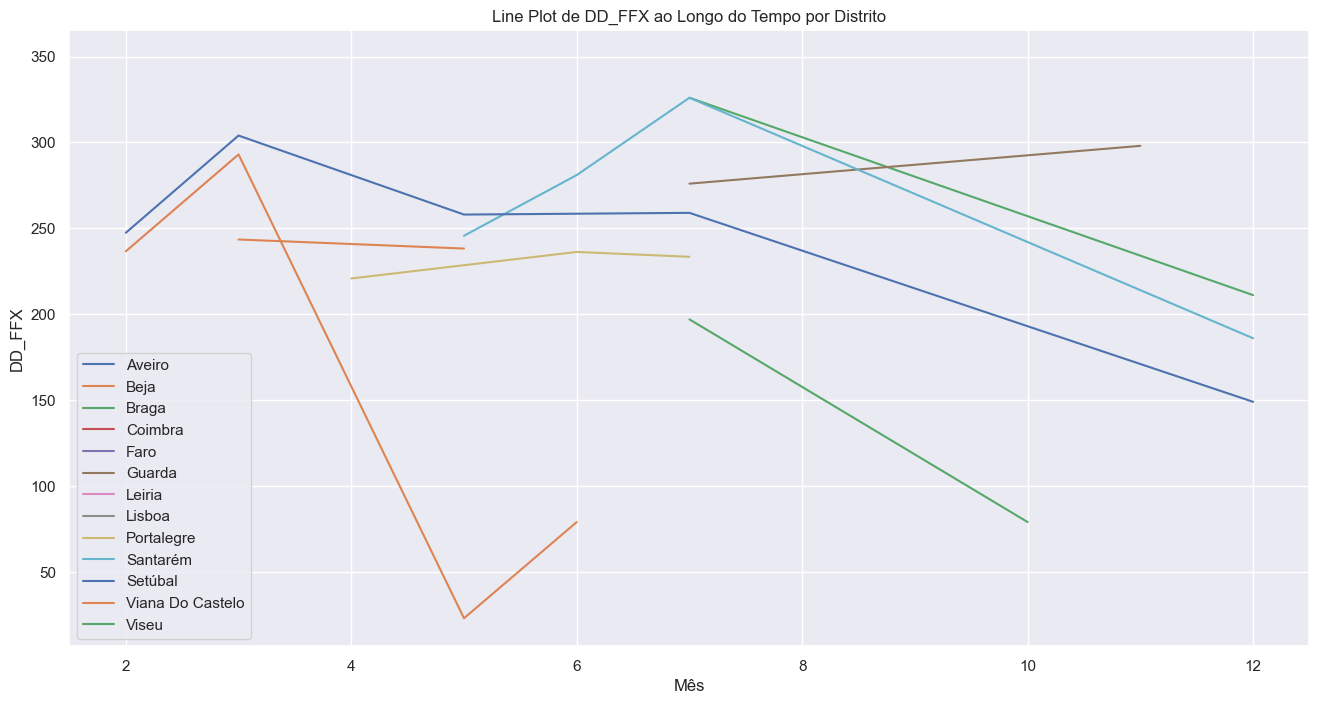

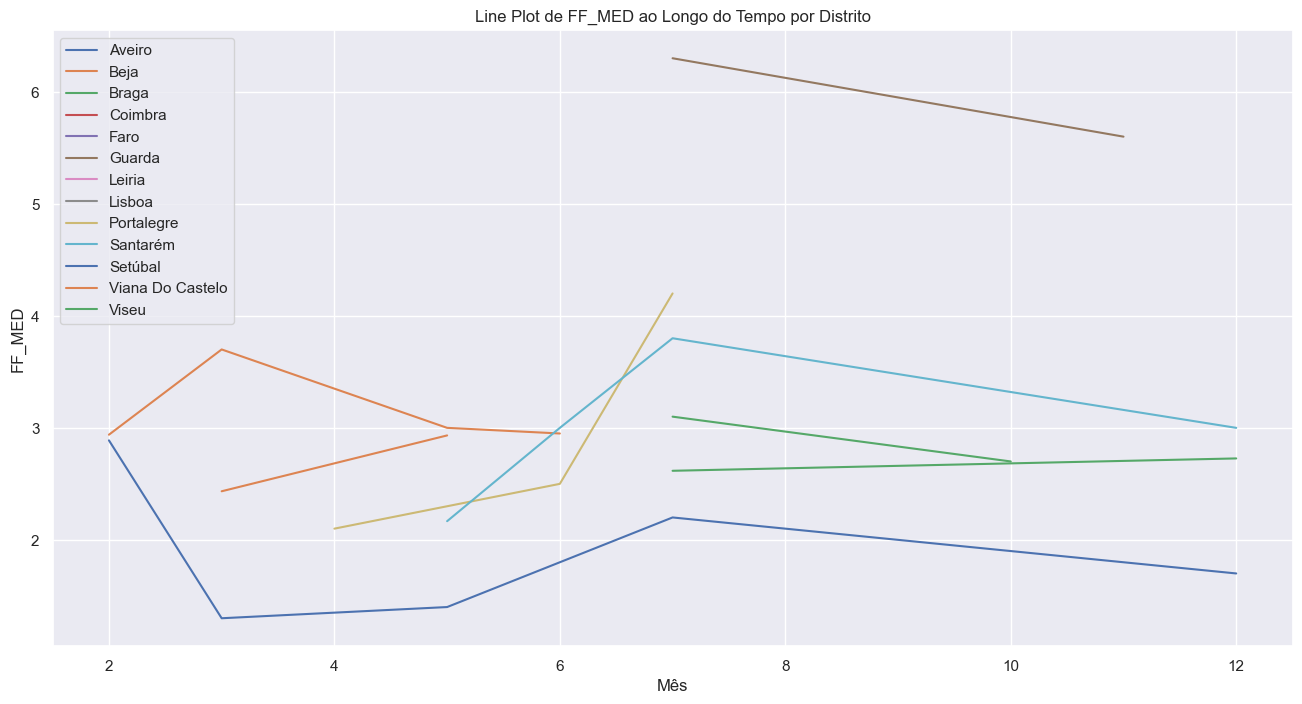

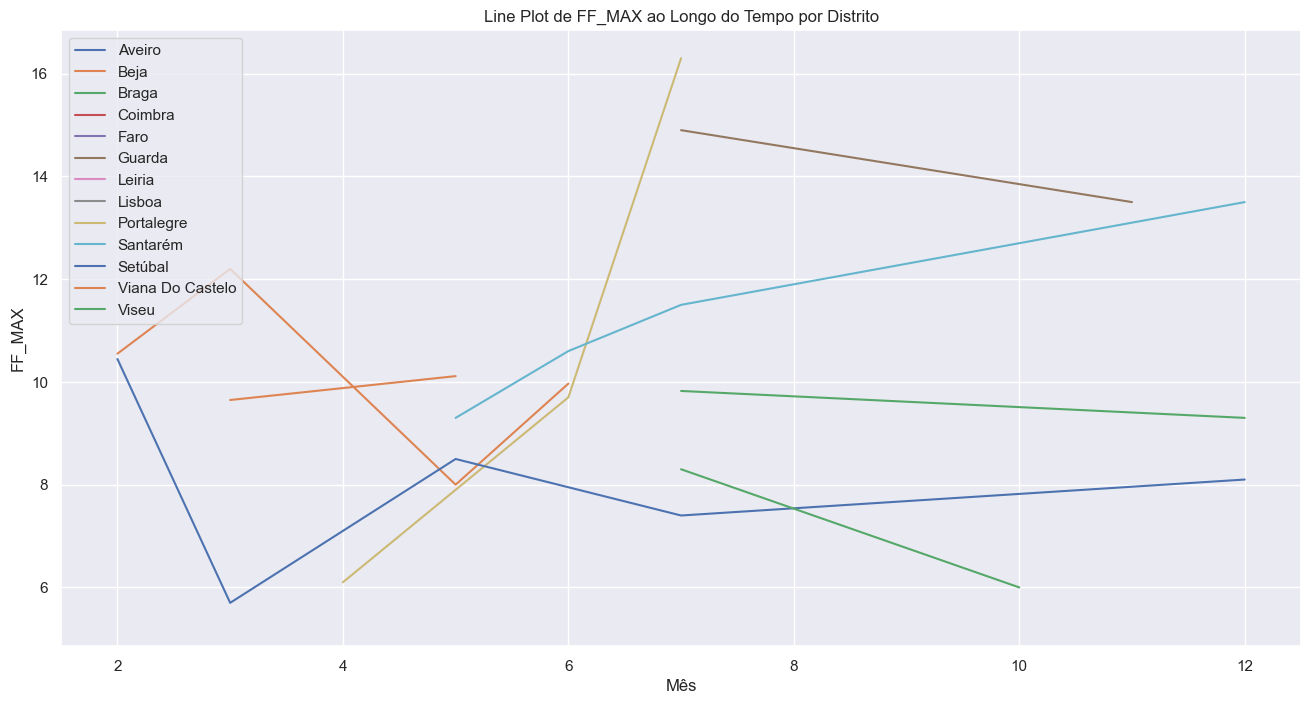

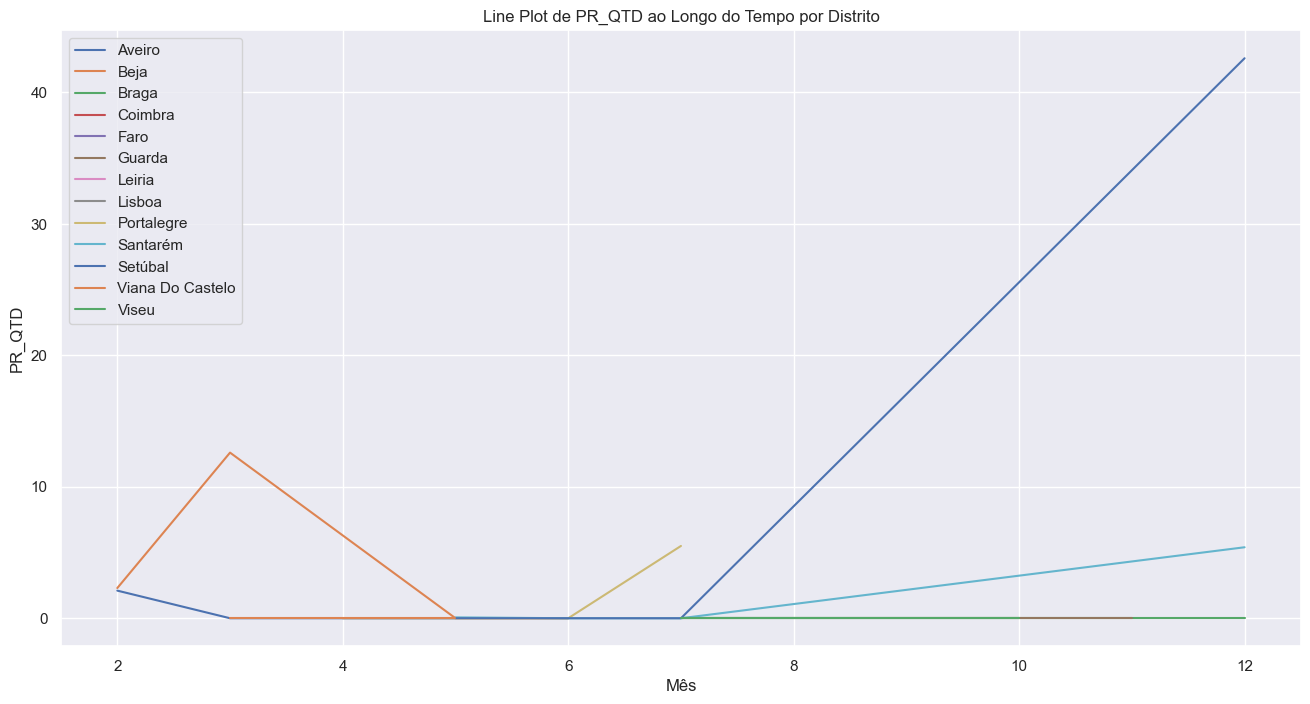

In [26]:
# Definir o estilo do Seaborn
sns.set_style("darkgrid")
tips = sns.load_dataset('tips')
sns.set_context('notebook', font_scale=1)

# Variáveis a plotar
variaveis = ['TIEPI MT (min)', 'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)', 'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']

# Loop sobre cada variável
for variavel in variaveis:
    # Criar um novo gráfico para cada variável
    plt.figure(figsize=(16, 8))
    
    # Agrupar os dados por distrito
    grupos_por_distrito = Visualizar.groupby('Distrito')
    
    # Loop sobre cada grupo (distrito)
    for nome_distrito, dados_distrito in grupos_por_distrito:
        # Plotar a linha da variável para o distrito atual
        sns.lineplot(data=dados_distrito, x='Mês', y=variavel, label=nome_distrito, markers=True, dashes=False)

    # Adicionar título e etiquetas dos eixos
    plt.title(f'Line Plot de {variavel} ao Longo do Tempo por Distrito')
    plt.xlabel('Mês')
    plt.ylabel(variavel)
    
    # Mostrar a legenda
    plt.legend()
    
    # Mostrar o gráfico para a variável atual
    plt.show()


In [27]:
QuebrasFinal[QuebrasFinal["Causa do incidente"]=="Furtos"]

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
225,EDPD_2018_MAI_T_48,Maia,2018-05-21,BT,Furtos,329.0,148.0,0.0,0.0,0.0,...,119.2,0.000000,15.2,17.7,13.5,187.000000,214.000000,3.500000,9.000000,0.00000
566,EDPD_2018_DEZ_T_13,Porto,2018-12-10,BT,Furtos,208.0,56.0,0.0,0.0,0.0,...,205.5,0.000000,14.8,19.7,10.3,94.000000,96.000000,4.900000,10.000000,0.00000
1492,EREDES_2022_NOV_T_22,Marinha Grande,2022-11-17,BT,Furtos,323.0,69.0,0.0,0.0,0.0,...,182.8,1.000000,16.3,19.7,11.6,248.000000,243.000000,2.500000,11.800000,12.10000
1795,EDPD_2019_JUN_T_30,Batalha,2019-06-18,BT,Furtos,164.0,118.0,0.0,0.0,0.0,...,149.9,1.000000,18.8,23.5,11.1,180.000000,198.000000,4.000000,12.300000,0.50000
2336,EDPD_2020_JUL_T_51,Porto De Mós,2020-07-27,BT,Furtos,174.0,70.0,0.0,0.0,0.0,...,192.0,1.000000,19.2,24.4,13.3,312.000000,326.000000,3.200000,10.800000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7113,EDPD_2017_SET_T_74,Cartaxo,2017-09-26,BT,Furtos,10.0,5.0,0.0,0.0,0.0,...,177.7,1.000000,19.3,30.9,12.0,312.000000,281.000000,2.600000,8.900000,0.00000
7121,EDPD_2017_SET_T_82,Ílhavo,2017-09-20,BT,Furtos,91.0,1.0,0.0,0.0,0.0,...,137.1,0.000000,15.9,20.4,12.9,219.882693,224.242804,3.191167,9.803617,0.00000
7155,EDPD_2017_OUT_T_17,Carregal Do Sal,2017-10-11,BT,Furtos,83.0,72.0,0.0,0.0,0.0,...,233.9,1.000000,21.8,29.2,17.1,339.000000,326.000000,2.700000,8.400000,0.00000
7181,EDPD_2017_OUT_T_52,Ílhavo,2017-10-08,BT,Furtos,81.0,2.0,0.0,0.0,0.0,...,137.1,0.000000,18.3,29.4,11.3,206.706002,233.180792,2.640847,9.186637,0.00000


In [28]:
QuebrasFinal["Causa do incidente"].unique()

array(['Veículos', 'Escavações', 'Incêndio', 'Animais Não Aves',
       'Abate De Árvores', 'Intervenções À Superficie', 'Furtos',
       'Descarga Atmosférica Directa', 'Vento Intensidade Excepcional',
       'Malfeitoria/Vandalismo', 'Inundações Imprevisíveis',
       'Desabamento De Muros/Outras Cons', 'Corpos Estranhos Na Rede',
       'Risco Iminente Pessoas Ou Bens', 'Aves',
       'Desabamento De Muros/Outras Construções', 'Sabotagem',
       'Deslizamento De Terras', 'Trabalhos De Terceiros ( Gruas,... )',
       'Ruptura De Canal. De Fluídos', 'Malfeitorioa (Vandalismo)'],
      dtype=object)